In [1]:
#-------standar Libraries
import pandas as pd
import numpy as np

#------plots
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px 
from matplotlib.axis import Axis

#-----dateFormat
from datetime import date

# Raw Data

In [3]:
contratos.head()

,Unnamed: 0,company_id,approval_date,id
0,10,08e40343-54aa-49d1-9317-4dbcd16ee70f,2021-11-16,5594b56e-eb5d-4ac3-b52e-7d3fb41b05ce
1,14,0c60cc83-42ac-4229-9cdd-3a2887400d32,2022-06-16,ea6eb172-0a88-4abb-bf37-477ddc1afeb5
2,35,23e567c2-874f-45f5-b948-bc344f3ffd6a,2022-07-28,04c0da85-8291-4a68-80be-c1150c59c385
3,42,2d7df42a-eaf3-4de9-986f-e019dc266734,2022-05-18,0399c511-76cb-4330-a429-4eeaafae21da
4,70,456f807a-8a8d-46e2-9673-d6e062b0a56f,2022-08-07,96e1f3e2-626b-488b-b986-1c43da1b2771


In [4]:
ventas.head()

,Unnamed: 0,date,sales,client_id
0,0,2022-04-10,196865.25,08e40343-54aa-49d1-9317-4dbcd16ee70f
1,1,2022-04-19,275584.92,08e40343-54aa-49d1-9317-4dbcd16ee70f
2,2,2022-04-29,57693.56,08e40343-54aa-49d1-9317-4dbcd16ee70f
3,3,2022-05-27,354177.19,08e40343-54aa-49d1-9317-4dbcd16ee70f
4,4,2021-10-12,231843.95,08e40343-54aa-49d1-9317-4dbcd16ee70f


From these two tables we have a link between the *company_id* in the contracts file and the *client_id* in the sales file, so that we can extract the daily sales from each company as follows

In [5]:
ventas[ventas['client_id']==contratos['company_id'][0]].head()

,Unnamed: 0,date,sales,client_id
0,0,2022-04-10,196865.25,08e40343-54aa-49d1-9317-4dbcd16ee70f
1,1,2022-04-19,275584.92,08e40343-54aa-49d1-9317-4dbcd16ee70f
2,2,2022-04-29,57693.56,08e40343-54aa-49d1-9317-4dbcd16ee70f
3,3,2022-05-27,354177.19,08e40343-54aa-49d1-9317-4dbcd16ee70f
4,4,2021-10-12,231843.95,08e40343-54aa-49d1-9317-4dbcd16ee70f


As a first plot let us consider the number of reported sales per company:

In [6]:
#Number of  reported sales per company 
ventas_per_company=[]
for i in range(20): #There are 20 companies
    ventas_per_company.append(ventas[ventas['client_id']==contratos['company_id'][i]].shape[0])

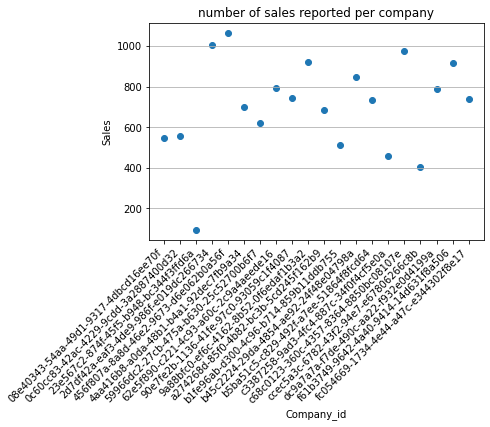

In [7]:
plt.scatter(contratos['company_id'],ventas_per_company)
plt.grid(axis='y')
plt.xlabel('Company_id')
plt.ylabel('Sales')
plt.title('number of sales reported per company')
plt.xticks(rotation=45, ha='right')
plt.show()

From the plot above we have that some companies share a similar number of reported sales. A naive analysis from this is to cluster companies with respect to the number reported, but a more in depth analysis is needed, since it might only represent it is either a new company or a company that recently reported (to Fairplay) their sales. 

*** 

## Particular Analysis (One Company)

Let us take one company and see how their sales behave before and after the loan was approved. To exemplify this we consider the company which  has the lowest number of reported sales in the plot above. 

In [8]:
idx=contratos['company_id'][2]
idx

'23e567c2-874f-45f5-b948-bc344f3ffd6a'

In [9]:
ventas_company=ventas[ventas['client_id']==idx]
ventas_company.shape 

(92, 4)

For this company only 92 reported sales are available. Their loan's aproval date is

In [10]:
contratos[contratos['company_id']==idx]['approval_date']

2    2022-07-28
Name: approval_date, dtype: object

Let us now sort the sales by the date the were reported as follows:

In [11]:
ventas_sorted=ventas_company.sort_values(by='date')

In [12]:
print('initial date', ventas_sorted['date'].iloc[0])
print('final date', ventas_sorted['date'].iloc[-1])

initial date 2022-06-01
final date 2022-08-31


Notice this company only at most two months of reported sales, hence the lowest value in the above plot. For a more easily manage of date let us parse them into the datetime format.

In [13]:
ventas_sorted['date']= pd.to_datetime(ventas_sorted['date'])

As a first analysis of their sales, we plot their trend month. Let us remark that this only shows that most of the reported sales are after the first month.

In [14]:
X=np.unique(ventas_sorted['date'].map(lambda x: x.month))
Y=ventas_sorted.groupby(ventas_sorted['date'].map(lambda x: x.month)).size()

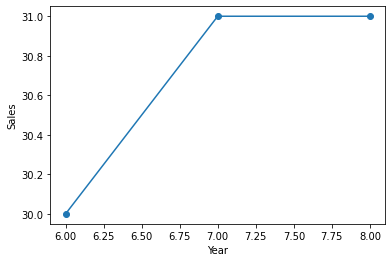

In [15]:
plt.plot(X,Y, marker='o')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.show()

However if we look closer at the sales we then notice that this company has all their sales empty, reported with zero value.

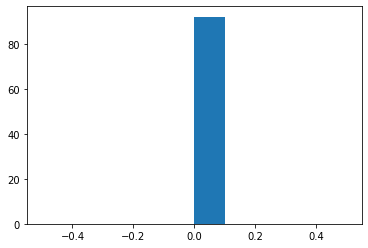

In [16]:
plt.hist(ventas_sorted['sales'])
plt.show()

To continue with our analysis, let us repeat the same process but with a different company. 

In [17]:
idx=contratos['company_id'].iloc[-4]
ventas_company=ventas[ventas['client_id']==idx]
print('%f reported sales' %ventas_company.shape[0])
aprov_date=contratos[contratos['company_id']==idx]['approval_date'].iloc[0]
print('approval date', aprov_date)
ventas_sorted=ventas_company.sort_values(by='date')
print('initial date', ventas_sorted['date'].iloc[0],'final date', ventas_sorted['date'].iloc[-1])

403.000000 reported sales
approval date 2021-11-10
initial date 2021-07-25 final date 2022-08-31


Let us now consider a plot their sales daily and mask the sales after the approval date in another color, and so we have: 

In [18]:
mask = (ventas_sorted['date'] >= aprov_date)

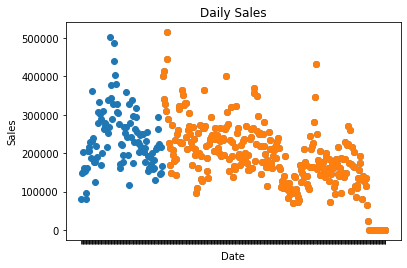

In [19]:
fig = plt.figure() 
ax = fig.add_subplot() 
plt.scatter(ventas_sorted['date'],ventas_sorted['sales'], marker='o')
plt.scatter(ventas_sorted[mask]['date'],ventas_sorted.loc[mask]['sales'], marker='o')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Daily Sales')
ax.xaxis.set_ticklabels([])
plt.show()

From this plot we notice right away that the granular study was too thin, however, we might conjecture that indeed the loan was of help, it seems the sales were stables after the loan, but we need to take into account a more specified study, say the trend the company has montly, or to analyse the sells in a time window around the approval date. Here we need more information of the companay to conclude if the loan was of help right away.


Observe at the end of the plot, closer to today, we have some values clustered as zero. This as we see below corresponds to sales that hasn't happened yet. We then only consider the sales up to the current month.

In [20]:
ventas_sorted['date'].iloc[-1] #Last day of reported sales

'2022-08-31'

In [21]:
ventas_sorted=ventas_sorted[ventas_sorted['date'] < '2022-08' ]
mask = (ventas_sorted['date'] >= aprov_date)

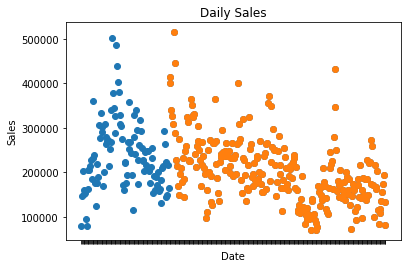

In [22]:
fig = plt.figure() 
ax = fig.add_subplot()
plt.scatter(ventas_sorted['date'],ventas_sorted['sales'], marker='o')
plt.scatter(ventas_sorted[mask]['date'],ventas_sorted.loc[mask]['sales'], marker='o')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Daily Sales')
ax.xaxis.set_ticklabels([])
plt.show()

Let us now consider a montly sales analysis, again using another color to show the montly sales after the loan was approved.

In [23]:
#gets the accumulated saled for each month
def get_sales_montly(ventas):
    dict_fechas={}
    for d in ventas['date']:
        year, month, _ = str(d).split("-")
        sales=float(ventas[ventas['date']==d]['sales'])
        #print(sales)
        llave = year + "-" + month
        if dict_fechas.get(llave) is None:
               dict_fechas[llave] = sales
        else:
            dict_fechas[llave] += sales
    return dict_fechas

In [24]:
mask = (ventas_sorted['date'] >= aprov_date[:-3])
df_aux=pd.DataFrame(get_sales_montly(ventas_sorted).items(),columns=['date','sales'])
df_aux_2=pd.DataFrame(get_sales_montly(ventas_sorted[mask]).items(),columns=['date','sales'])

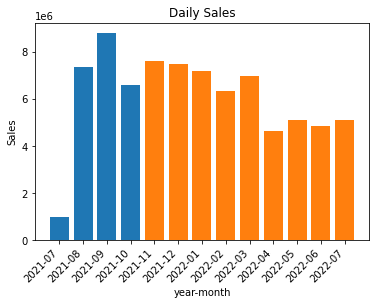

In [28]:
plt.bar(df_aux['date'],df_aux['sales'])
plt.bar(df_aux_2['date'],df_aux_2['sales'])
plt.xlabel('year-month')
plt.ylabel('Sales')
plt.title('Daily Sales')
plt.xticks(rotation=45, ha='right')
plt.show()

We now have that in a montly sales analysis,  the sales decreased after the loan, to see how significat such increment is we are now gonna use a boxplot.

In [ ]:
ventas_sorted['date'] = pd.to_datetime(ventas_sorted['date'])
fechas_list=list(np.unique(ventas_sorted['date'].dt.to_period('M')))
fechas_list=[ str(x) for x in fechas_list]

In [ ]:
month_sales=[]
for i in range(len(fechas_list)-1):
    pd_aux=ventas_sorted[(ventas_sorted['date']>= str(fechas_list[i])) & (ventas_sorted['date']<str(fechas_list[i+1]))]['sales']
    month_sales.append(list(pd_aux))

In [ ]:
i=fechas_list.index(aprov_date[:-3])
plt.boxplot(month_sales,showmeans=True)
plt.axvline(x=i+1,color='red')
plt.axhline(y=np.mean(month_sales[i]),color='g',linestyle='--',alpha=0.4)
plt.show()

With this new plot we could argue that although the sales did not reach the previous sales peak before the loan, they have been stable, even more, as noted in the box plot, some outliers are found those represent either really good sales or bad sales, and we have more *good sales* after the loan.

*** 

# General Analysis

To generalize such analysis we have to consider the approval date for each company

In [ ]:
for idx in contratos['company_id']:
    #print(idx)
    pd_aux=ventas[ventas['client_id']==idx]
    pd_aux=pd_aux[pd_aux['date']<'2022-08']
    list_aux=list(pd_aux.sort_values(by='date')['date'])
    print('reported sales:',list_aux[0],'to',list_aux[-1])
    print('aproval date:',list(contratos[contratos['company_id']==idx]['approval_date'])[0])
    print(10*'--')
    

At this point we now compute the corresponding montly plots for each company, as well as their respective boxplot, the vertical line (red) represents the month in which the loan was approved, and the horizontal line (green) is aligned to the mean of sales in such month.


We make use of the following functions

In [31]:
def montly_sales_plot(ventas,aproval_date_ym):
    #mask the dates after the aproval date
    mask = (ventas['date'] >= aproval_date_ym )
    #create two dataframes with respective sales
    df_aux=pd.DataFrame(get_sales_montly(ventas).items(),columns=['date','sales'])
    #sales after loan
    df_aux_2=pd.DataFrame(get_sales_montly(ventas[mask]).items(),columns=['date','sales'])
    
    #plots 
    plt.bar(df_aux['date'],df_aux['sales'],label='sales')
    if not df_aux_2.empty:
        plt.bar(df_aux_2['date'],df_aux_2['sales'],label='sales after loan')
    plt.xlabel('Date')
    plt.title('Montly Sales')
    plt.legend()
    plt.xticks(rotation=45, ha='right')
    #plt.figure(figsize=(4,4))
    plt.show()
    
    
def montly_sales_boxplot(ventas_sorted,approval_date_ym):
    #parse the dates into a suitable format
    ventas_sorted['date'] = pd.to_datetime(ventas_sorted['date'])
    #List of all years and moths in format yyyy-mmm
    fechas_list=list(np.unique(ventas_sorted['date'].dt.to_period('M')))
    fechas_list=[ str(x) for x in fechas_list]
    #print(fechas_list)
    
    #get all the sales between the above dates
    month_sales=[] #store the list of the sales
    for i in range(len(fechas_list)-2):
        #get the sales from the first month up to the next month
        pd_aux=ventas_sorted[(ventas_sorted['date']>= fechas_list[i]) & (ventas_sorted['date']<fechas_list[i+1])]['sales']
        month_sales.append(list(pd_aux))
    
    #print([len(lista) for lista in month_sales])
        
    #set the x value by getting the month the approval date belongs to
    x_aproval=fechas_list.index(approval_date_ym)
    
    #----plots----
    bp=plt.boxplot(month_sales,showmeans=True)
    plt.axvline(x=x_aproval+1,color='red')
    means = [item.get_ydata()[0] for item in bp['means']]
    try: 
        plt.axhline(y=np.mean(means[x_aproval]),color='g',linestyle='--',alpha=0.4)
    except:
        pass
    plt.title('montly sales')
    plt.show()

Figure 1


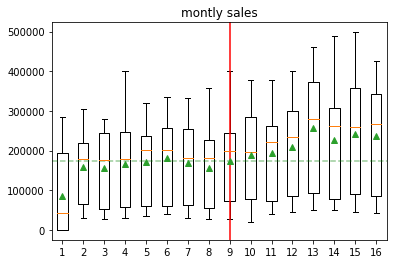

Figure 2


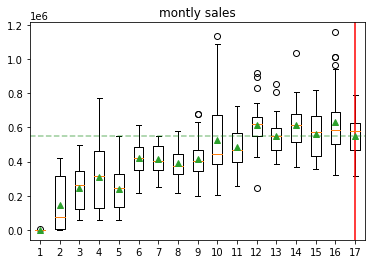

Figure 3


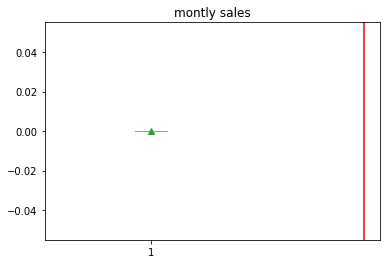

Figure 4


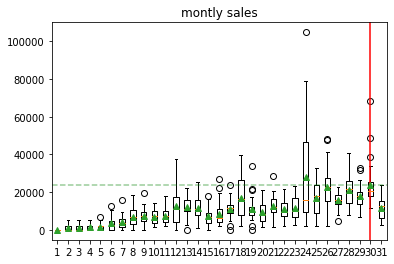

Figure 5


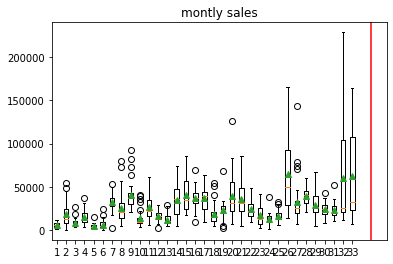

Figure 6


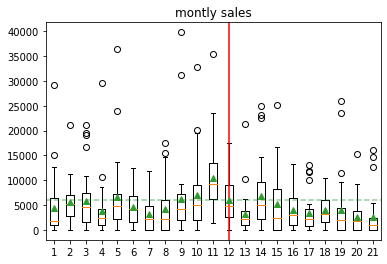

Figure 7


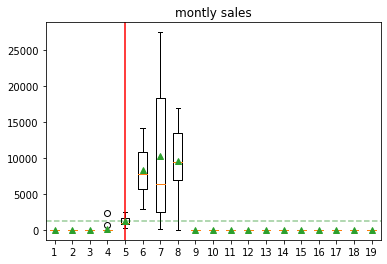

Figure 8


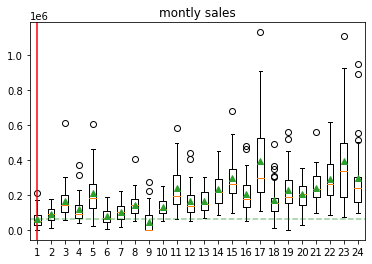

Figure 9


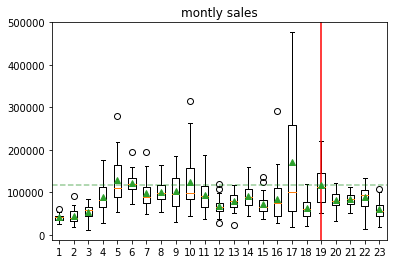

Figure 10


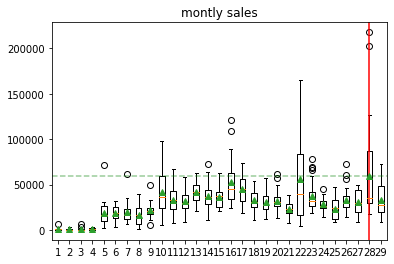

Figure 11


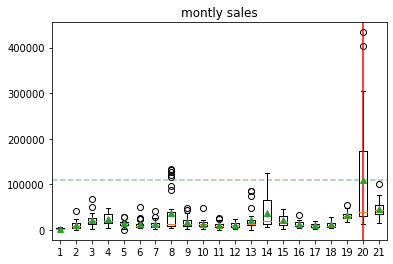

Figure 12


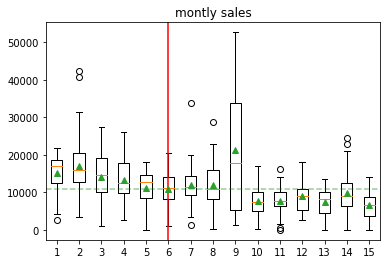

Figure 13


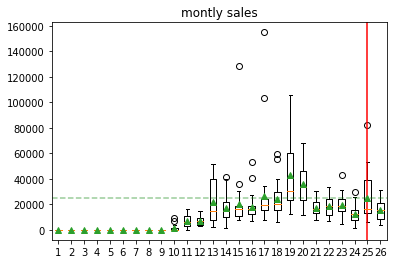

Figure 14


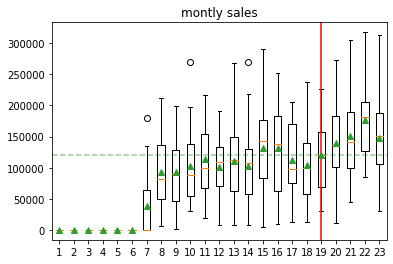

Figure 15


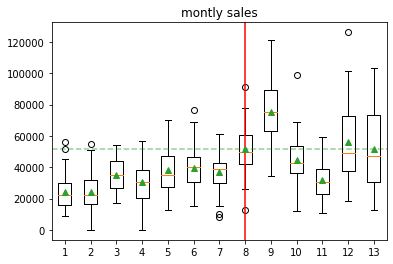

Figure 16


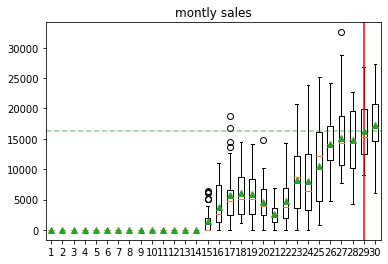

Figure 17


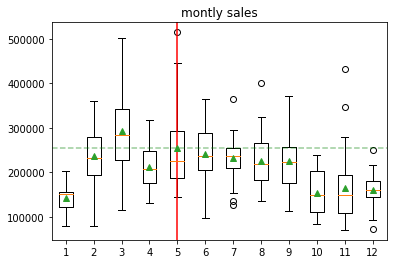

Figure 18


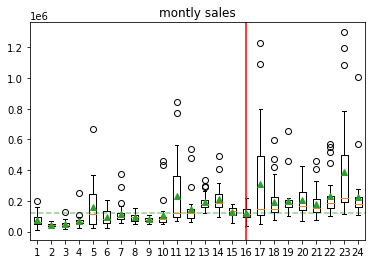

Figure 19


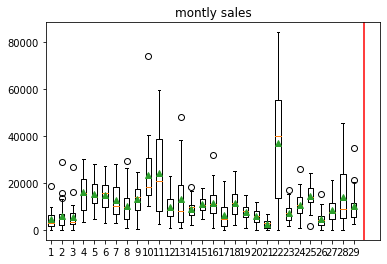

Figure 20


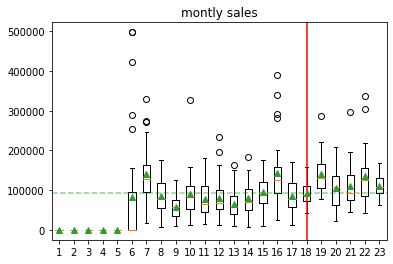

In [32]:
i=1
for idx in contratos['company_id']:
    #print(idx)
    ventas_temp=ventas[ventas['client_id']==idx]
    ventas_sorted_temp=ventas_temp.sort_values(by='date')
    #ventas_sorted_temp=ventas_sorted_temp[ventas_sorted_temp['date'] <= '2022-09' ] #Remove the last month
    aproval_date=list(contratos[contratos['company_id']==idx]['approval_date'])
    aproval_date=aproval_date[0][0:7]
    #print(aproval_date)
    print('Figure %i' %i)
    montly_sales_boxplot(ventas_sorted_temp,aproval_date)    
    i=i+1

Figure 1


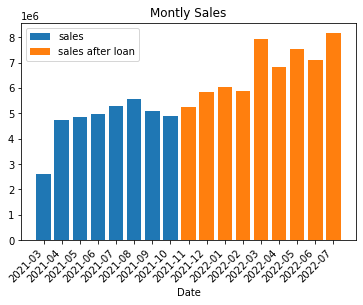

Figure 2


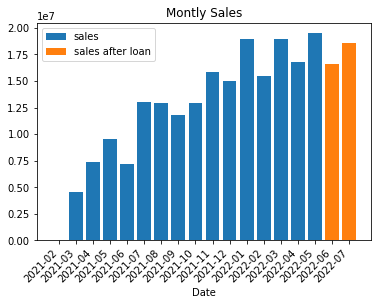

Figure 3


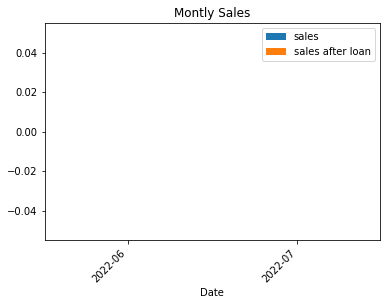

Figure 4


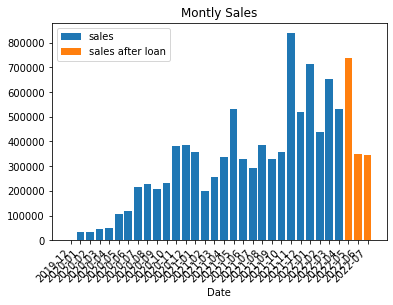

Figure 5


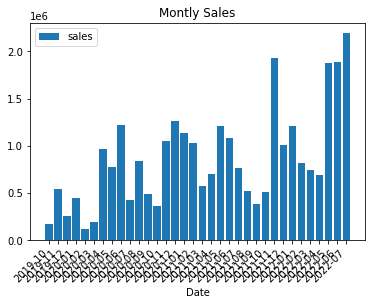

Figure 6


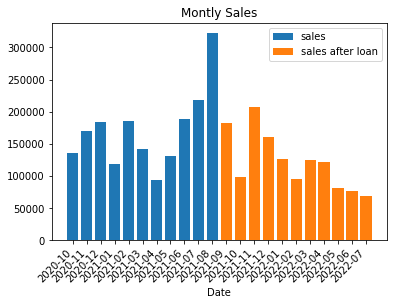

Figure 7


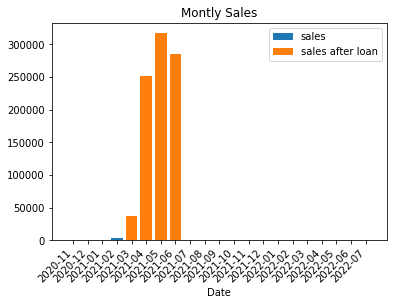

Figure 8


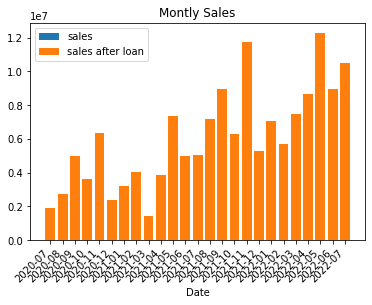

Figure 9


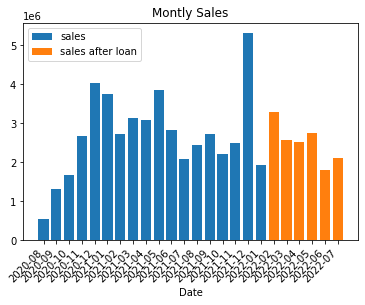

Figure 10


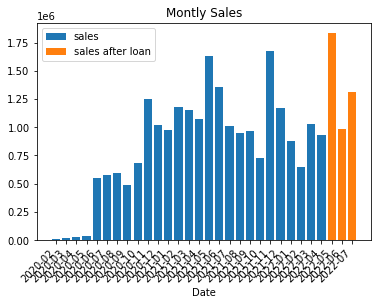

Figure 11


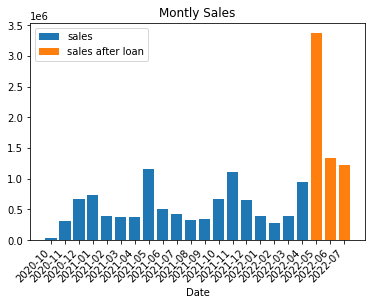

Figure 12


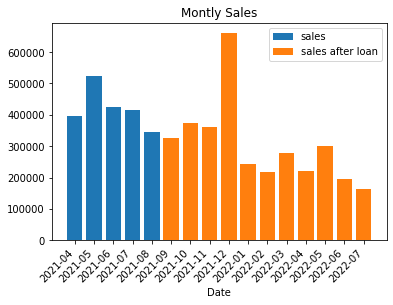

Figure 13


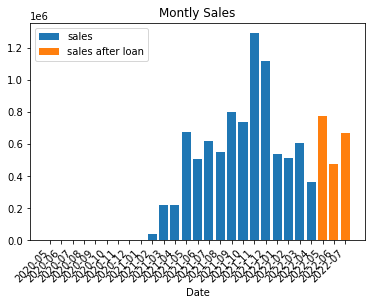

Figure 14


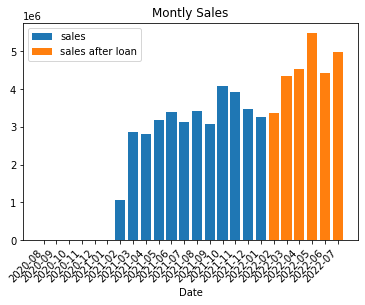

Figure 15


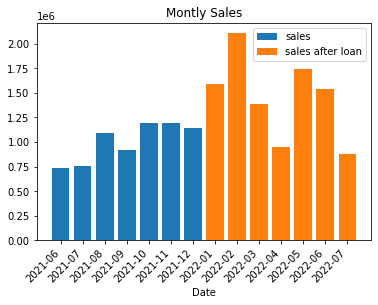

Figure 16


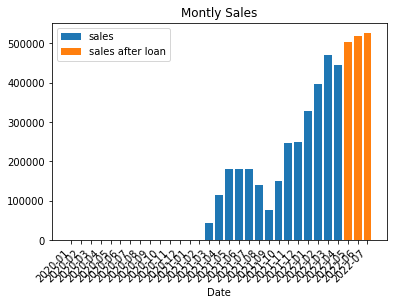

Figure 17


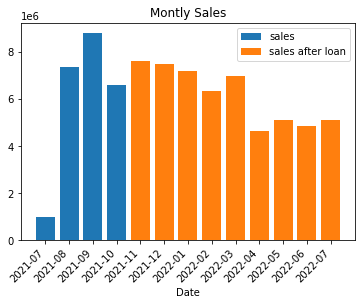

Figure 18


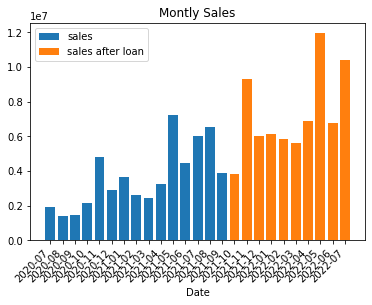

Figure 19


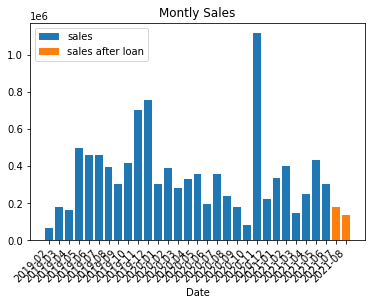

Figure 20


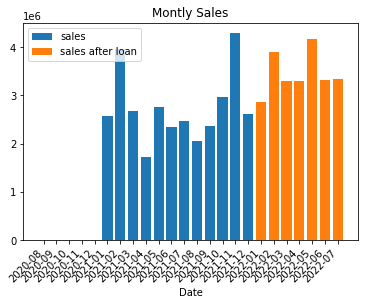

In [30]:
i=1
for idx in contratos['company_id']:
    #print(idx)
    ventas_temp=ventas[ventas['client_id']==idx]
    ventas_sorted_temp=ventas_temp.sort_values(by='date')
    ventas_sorted_temp=ventas_sorted_temp[ventas_sorted_temp['date'] < '2022-08' ] #Remove the last month
    aproval_date=list(contratos[contratos['company_id']==idx]['approval_date'])
    aproval_date=aproval_date[0][0:7]
    #print(aproval_date)
    print('Figure %i' %i)
    montly_sales_plot(ventas_sorted_temp,aproval_date)  
    i=i+1

Some remarks are given in order: 
    
    1. For some companies we have no report of their sales, and so there needs to a more in depth analysis of such phenomenon.
    
    2. As seen in the plots above, some companies have empty months, say the sales in those months are reported as zero.
    
    3. Others, have few sales reportes prior to the loan, and so to say how the loan was of help is difficult, since we could argue that their sales went up, but then apparently close, see Figure 7 in the plots above.
    
    4. We have companies that started reporting their sales right after their loan, and so again, to study the help of the loan is an ambiguous task, see Figure 8 in the plots above. 
    
    5. On the hand, there are companies that their loan was approved quite recently, and so no history of montly sales is available yet, see Figure 5 and 19.
    
    6. For those companies that do not present the same problems mentioned before, we have that in general their sales were stable, or at least did not went down drastically, knowin that the year 2022 hasn't finished yet.
    
    7. Figures 14, 16, 18 and 20 seem to have a better sales trend after their loan, having their monlty sales with a mean sale going up. 
    
    8. We must remark that the companies that have atypical behavious as the ones decribed above might create a bias in the analysis, hence that information needs to be trated carefully and different.
    
    

In light of the above and considering the plots below, we cannot state whether the loan was of help for all, however with this analysis we could argue that each company has it own behaviour, hence exploting those plots individually, with extra information such as trends in theis sales, or what kind of product/service they offer might add value to such study.